<a href="https://colab.research.google.com/github/kylemath/EEG-Classification/blob/master/notebooks/CNN_LSTM_Muse_Kyle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CNN_LSTM_MUSE_Kyle

Goal is to make a CNN LSTM stack that processes Muse eeg-notebook EEG trials as input and predicts binary trial category as output.

Strategy:
* Load in Muse data, and turn into square images with n channels. 
* Try 49  by 49 data point long spectra for each trial 
* Predict attend left vs attend right on muse 375 data

API:
* Want to input the data directory of any eeg-notebook experiment (https://github.com/kylemath/eeg-notebooks) 

LearningModels:
* First try simple CNN
* then add in LSTM component to treat time as recurrent

DataModels:
* First pool data over subjects
* Try subject specific models
* Then try multilevel models

Using: 
* https://github.com/pbashivan/EEGLearn
* https://github.com/tevisgehr/EEG-Classification
* https://github.com/kylemath/eeg-notebooks
* https://github.com/keras-team/keras/blob/master/examples/imdb_cnn_lstm.py

Resources:
*   http://proceedings.mlr.press/v56/Thodoroff16.pdf
*   https://arxiv.org/abs/1511.06448




**TODO Kory Jan 20** 

1. substitute totally random data for your input data or 

14. Also, you can try `np.random.shuffle(y_train)` and see how it performs on randomly shuffled input data.         


16. Might want to use stratify on the train_test_split


20. I have no notion that it should be able to differentiate the two classes. Can you do any sort of unsupervised learning to show that there are significant differences in the distribution? Plot the distributions, scatter the PCA's in 2d, do something that shows that there is a separation line...  At this point,you can fiddle and futz with hyperparameters all day long, but there is nothing better than random performance for those features.

22. Plot loss with plt.semilogy

15. Also. Do you have a validation set? Best to ask early. 

21. How does number of features relate to number of data points relate to number of parameters? [link](https://www.youtube.com/watch?v=Dc0sr0kdBVI&hd=1#t=57m20s)

              
Done
1. this line is confusing?` sub = isub `
2. some long lines of code make it less readable... try to keep code within the dotted line
6. There are moments when raw sizes are printed, try to give them some context with

         `print( ' right cue data size: {}'format(tfr.data.shape))` 
          (1063, 2, 49, 49) (1063, 49, 49, 2) 
18. regarding epochs. Don't redefine `epochs = 100` it makes co rerunning hard.
8. `to_categorical()` before the train test split
7. not sure what I am seeing in the 2 subplots... there is a y-axis label missing for top / bottom
 * *Changed Label above, multi instances*
9. all your imports should go at the top of the file and not in the cell it is used in
4. for instance, there is a plot at the end of : `raw.plot_psd(fmin=1, fmax=30 );` that i missed because it was below 100 of the same status line
 * *removed it not important*
24. categorical_crossentropy was right for your categorical mod
12. loss function can be `binary_crossentropy` i think


        model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
              
14. Looks like it is over fitting on random noise and then performing about the same as a random baseline? Two balanced classes on output would give 50% accuracy. What is the output classes distritbution of training and test sets? 

   * *About Random 50/50* 
   
16. Looks like there is some signal found but not much. How long does training take? Time per epcoh/step
17. Plot you learning rate over time. Does it decay to zero?
  * *These are both in code output*
18. What is your batch size? Can you try with smaller batches? Bigger batches? Are batches shuffles after each epoch? 
  * *Tried these, small and large, no effect*
23. I use Adam almost consistently for optimizer
        opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, 
                            epsilon=None, decay=0.0, amsgrad=False)
24. Start with a very small model. Conv layers only. No lstm for instance. This could be a function of vanichsing gradients in the recurrent layers. 
20. What is the data shape? Can you show the whole input to the model rather than feeding in recurrent? 
  * *This is just a CNN right now, withonly two layers*
17. Also, you always want to set the random seed explicitly for ML research, `np.random.seed(1017)` random_state in train_test_split. this will help with reproducibility testing.
2. Long output logs are confusing as fuck. Can you use tqdm or something similar to show progress rather than listing a bit meaningless status?
10. add a `model.summary() ` somewhere, it gives you a sense of the model in plaintext. (Trainable params: 174,592) 11) 
11. you use two different definitions of the word epoch in the file. 
1. each cell (eg. 2) should have a status message if it succeded or failed.
2. mark each image with the answer and see if your CNN visual features can detect. 
15. You can use `np.ones_like` and `np.zeros_like` to make easy to discern training data. For instance, here is a sanity check, make all the left cues ones, and all the right cues zeros... then make a model that fits on that.


**Kyle TODO**

1. Allow different number of sessions per subject (array of number of sessions)
2. Remove decimation since no longer conv

**Setup**

In [1]:
!git clone https://github.com/tevisgehr/EEG-Classification.git
%cd EEG-Classification
from eeg_learn_functions import *
%cd ..

!git clone https://github.com/kylemath/eeg-notebooks.git
%cd eeg-notebooks/notebooks
!pip install mne
from utils import utils

import pandas as pd
pd.options.display.max_columns = None
pd.options.display.precision = 4

import numpy as np
from numpy import genfromtxt
np.random.seed(1017)

from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,12)

import seaborn as sns
import scipy.stats as scs
import re

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from mne import Epochs, find_events, concatenate_raws
from mne.time_frequency import tfr_morlet

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

from sklearn.model_selection import train_test_split



fatal: destination path 'EEG-Classification' already exists and is not an empty directory.
/content/EEG-Classification
/content
fatal: destination path 'eeg-notebooks' already exists and is not an empty directory.
/content/eeg-notebooks/notebooks


Using TensorFlow backend.


**Parameters**

In [185]:
#Parameters#
subs = [101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112,
        202, 203, 204, 205, 207, 208, 209, 210, 211, 
        301, 302, 303, 304, 305, 306, 307, 308, 309]

#subs = [ 205, 207, 208, 209]

#subs = [ 2]

nsesh = 2

data_dir = 'visual/cueing'
event_ids = ['LeftCue','RightCue']

#data_dir = 'visual/SSVEP'
#event_ids = ['F1','F2']


sfreq=256.

#filter
eeg_filter_highpass = 1
eeg_filter_lowpass = 30

#artifact rejection
rej_thresh_uV = 300
rej_thresh = rej_thresh_uV*1e-6

#trial epoch limits (must all work together with decimation and frequencies to create square) 
tmin=-1
tmax=2
decim=20
#times_out = int((((tmax-tmin) / (1/sfreq)) / decim)+1)
#img_rows, img_cols = times_out, times_out
baseline=(-1, 0)

#wavelet settings
f_low = 4
f_high = 20
f_bins = 10
frequencies =  np.linspace(4, 10, f_bins, endpoint=True)
wave_cycles = 6
spect_baseline = [-1,-.5]
electrodes_out = [0,1,2,3]

#Training Settings
batch_size = 32
train_epochs = 250
num_classes = len(event_ids)

print('Parameters Set')

Parameters Set


**Preprocessing of EEG Data**

* LoadData - Each data file is from one session of one subject of the muse cueing task from eeg-notebooks from psych 375 A1 dataset
* Filtering - Most ERP components are composed of lower frequency fluctuations in the EEG signal. Thus, we can filter out all frequencies between 1 and 30 hz in order to increase our ability to detect them.
* Epoching - Next, we will chunk (epoch) the data into segments representing the data 1000ms before to 2000ms after each cue, we will reject every epoch where the amplitude of the signal exceeded 100 uV, which should most eye blinks.

In [179]:
#Load Data
print('Loading Data')

isub = subs[0]
print(isub)
raw = utils.load_data(data_dir, sfreq=sfreq ,subject_nb=isub, session_nb=1)
if nsesh == 2:
  raw.append(utils.load_data(data_dir, sfreq=sfreq,subject_nb=isub, session_nb=2))

if len(subs)>1:
  for isub in subs[1:]:
    print(isub)
    raw.append(utils.load_data(data_dir, sfreq=sfreq,subject_nb=isub, session_nb=1))
    if nsesh == 2:
      raw.append(utils.load_data(data_dir, sfreq=sfreq,subject_nb=isub, session_nb=2))
  
#Filtering
print('Filtering Data')
raw.filter(eeg_filter_highpass,eeg_filter_lowpass, method='iir', verbose='WARNING' )
#raw.plot_psd(fmin=eeg_filter_highpass, fmax=eeg_filter_lowpass );

#Epoching
event_id = {event_ids[0]: 1, event_ids[1]: 2}
events = find_events(raw)
epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=tmin, tmax=tmax, baseline=baseline, 
                preload=True,reject={'eeg':rej_thresh},
                verbose=False, picks=[0, 1, 2, 3])

print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
%matplotlib inline
conditions = OrderedDict()
conditions[event_ids[0]] = [1]
conditions[event_ids[1]] = [2]

#fig, ax = utils.plot_conditions(epochs, conditions=conditions, ylim=(-20,20) )

Loading Data
101
102
103
104
105
106
108
109
110
111
112
202
203
204
205
207
208
209
210
211
301
302
303
304
305
306
307
308
309
Filtering Data
4583 events found
Event IDs: [ 1  2 11 12 21 22]
sample drop %:  68.6668121317914


** Spectrogram **

* All electrodes are considered on each trial, and their difference is used to create a single image for each trial.
* Two changes are made here to create a small square output for each trial.
* Many frequencies are used in the wavelet analysis (49) while the output of the morlet is decimated in time by a factor of 16. This creates 49x49 spectograms
* Now the other condition, right cue, is done, and the two sets of images and labels are concatenated into X and Y variables
* X is a trials x 49 x 49 matrix
* Y is a trials array of condition labels


In [180]:
# Condition0
print('Computing Morlet Wavelets on ' + event_ids[0])

tfr0 = tfr_morlet(epochs[event_ids[0]], freqs=frequencies, 
                      n_cycles=wave_cycles, return_itc=False,
                      picks=electrodes_out,average=False,decim=decim)
tfr0 = tfr0.apply_baseline(spect_baseline,mode='mean')
stim_onset = np.argmax(tfr0.times>0)
new_times = tfr0.times[stim_onset:]
cond0_power_out = np.moveaxis(tfr0.data[:,:,:,stim_onset:],1,3)
#cond0_power_out[:,0:5,0:5,:] = 0

print(event_ids[0] + ' Time Points: ' + str(len(new_times)))
print(event_ids[0] + ' Frequencies: ' + str(len(tfr0.freqs)))

#Condition1
print('Computing Morlet Wavelets on ' + event_ids[1])
tfr1 = tfr_morlet(epochs[event_ids[1]], freqs=frequencies, 
                      n_cycles=wave_cycles, return_itc=False,
                      picks=electrodes_out,average=False,decim=decim)
tfr1 = tfr1.apply_baseline(spect_baseline,mode='mean')
cond1_power_out = np.moveaxis(tfr1.data[:,:,:,stim_onset:],1,3)
#cond1_power_out[:,0:5,0:5,:] = 1

print(event_ids[1] + ' Time Points: ' + str(len(new_times)))
print(event_ids[1] + ' Frequencies: ' + str(len(tfr1.freqs)))




Computing Morlet Wavelets on LeftCue
Applying baseline correction (mode: mean)
LeftCue Time Points: 26
LeftCue Frequencies: 10
Computing Morlet Wavelets on RightCue
Applying baseline correction (mode: mean)
RightCue Time Points: 26
RightCue Frequencies: 10


**Prepare Data for Model**


Combined X Shape: (1436, 10, 26, 4)
Combined Y Shape: (1436,)
Combined Y: [0. 0. 0. ... 1. 1. 1.]
-15.542384240504429
25.812812793081022
Input Shape: (10, 26, 4)
x_train shape: (1148, 10, 26, 4)
1148 train samples
288 test samples
X Examples:


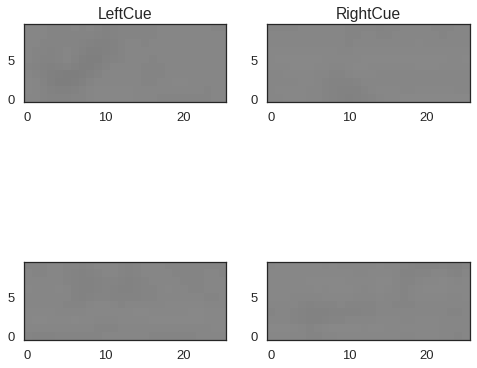

In [182]:
#Append Data
X = np.append(cond0_power_out,cond1_power_out,0);
Y = np.append(np.zeros(len(cond0_power_out)), np.ones(len(cond1_power_out)),0);

print('Combined X Shape: ' + str(X.shape))
print('Combined Y Shape: ' + str(Y.shape))
print('Combined Y: ' + str(Y))

X = (X - np.mean(X)) / np.std(X)

print(np.min(X))
print(np.max(X))

vmin = (np.std(X)) * -1
vmax = np.std(X)  

#Plot Example Data
f, axarr = plt.subplots(2,2, figsize = (8,8))
axarr[0][0].set_title(event_ids[0])
axarr[0][0].imshow(X[0,:,:,1],vmin=vmin, vmax=vmax)

axarr[0][0].invert_yaxis()
axarr[1][0].imshow(X[1,:,:,1],vmin=vmin, vmax=vmax)
axarr[1][0].invert_yaxis()

axarr[0][1].set_title(event_ids[1])
axarr[0][1].imshow(X[-1,:,:,1],vmin=vmin, vmax=vmax)
axarr[0][1].invert_yaxis()
axarr[1][1].imshow(X[-2,:,:,1],vmin=vmin, vmax=vmax)
axarr[1][1].invert_yaxis()
;

# convert class vectors to binary class matrices and recast X
Y = keras.utils.to_categorical(Y, num_classes)
X = X.astype('float32')

# Split training and test data and recast
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20,shuffle=True)

# Compute model input shape
input_shape = (X.shape[1], X.shape[2], len(electrodes_out))

print('Input Shape: ' + str(input_shape))
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('X Examples:')


**Build Model and Train**

Train on 1148 samples, validate on 288 samples
Epoch 1/250
1148/1148 [==============================] - 3s 3ms/step - loss: 0.8975 - acc: 0.4991 - val_loss: 0.7043 - val_acc: 0.5069
Epoch 2/250
1148/1148 [==============================] - 0s 184us/step - loss: 0.7433 - acc: 0.5270 - val_loss: 0.7168 - val_acc: 0.5000
Epoch 3/250
1148/1148 [==============================] - 0s 189us/step - loss: 0.6964 - acc: 0.5357 - val_loss: 0.7388 - val_acc: 0.5139
Epoch 4/250
1148/1148 [==============================] - 0s 195us/step - loss: 0.6999 - acc: 0.5444 - val_loss: 0.7066 - val_acc: 0.4965
Epoch 5/250
1148/1148 [==============================] - 0s 185us/step - loss: 0.6919 - acc: 0.5331 - val_loss: 0.7259 - val_acc: 0.5417
Epoch 6/250
1148/1148 [==============================] - 0s 195us/step - loss: 0.6892 - acc: 0.5366 - val_loss: 0.7093 - val_acc: 0.5139
Epoch 7/250
1148/1148 [==============================] - 0s 187us/step - loss: 0.6723 - acc: 0.5470 - val_loss: 0.7068 - val_acc: 0.5

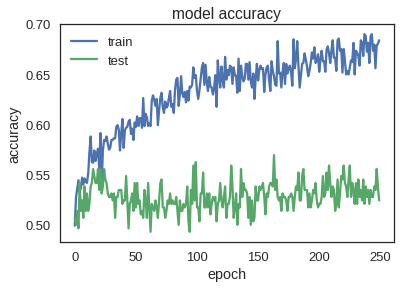

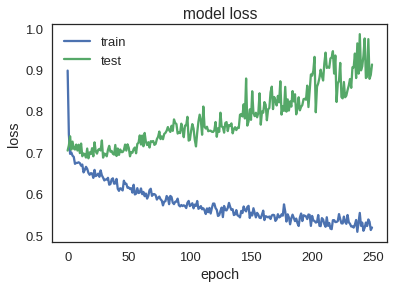

In [186]:
#DenseFeedforward Network
model = Sequential()
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(.20))
model.add(Dense(2, activation='softmax'))


#model.add(Dropout(.10))

# Create CNN in keras
#model = Sequential()
#model.add(Conv2D(49, (3, 3), input_shape=input_shape))
#model.add(Activation('relu'))
#model.add(Conv2D(32, (3, 3)))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Flatten())
#model.add(Dense(10))
#model.add(Activation('relu'))
#model.add(Dense(num_classes))
#model.add(Activation('softmax'))

# initiate adam optimizer
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, 
                            epsilon=None, decay=0.0, amsgrad=False)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])



#Train Model
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=train_epochs,
          validation_data=(x_test, y_test),
          shuffle=True,
          verbose=True)
         
#Summarize
model.summary()
 
  
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()